In [70]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from darts import TimeSeries
from darts.models import NLinearModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from pytorch_lightning.callbacks import EarlyStopping
from torchmetrics import MetricCollection, MeanAbsoluteError, MeanSquaredError

In [59]:
base_path = 'sample_csv/'
# base_path = 'stock_data_kr/'

column_mapping = {
    '일자': 'date',
    '종가': 'closing_price',
    '대비': 'price_difference',
    '등락률': 'fluctuation_rate',
    '시가': 'opening_price',
    '고가': 'highest_price',
    '저가': 'lowest_price',
    '거래량': 'trading_volume',
    '거래대금': 'trading_value',
    '시가총액': 'market_capitalization',
    '상장주식수': 'listed_shares',
}

In [60]:
stock_df = pd.read_csv(os.path.join(base_path, '005930_삼성전자_20000101_20230331.csv')).rename(columns=column_mapping)

stock_df.head()

,date,closing_price,price_difference,fluctuation_rate,opening_price,highest_price,lowest_price,trading_volume,trading_value,market_capitalization,listed_shares
0,2023/03/31,64000,800,1.27,64000,64000,63700,14094479,900711556583,382066083200000,5969782550
1,2023/03/30,63200,500,0.80,63700,63700,63100,15684377,993903387442,377290257160000,5969782550
2,2023/03/29,62700,-200,-0.32,62500,62700,62200,11216008,700455977590,374305365885000,5969782550
3,2023/03/28,62900,800,1.29,62400,62900,62100,11614118,726295104112,375499322395000,5969782550
4,2023/03/27,62100,-900,-1.43,62600,62800,62000,11039331,687170094400,370723496355000,5969782550


과거 공변량:
<ol>
    <li>과거 주가 데이터: 종가, 시가, 고가, 저가 등
    <li>거래량: 주식 거래량 데이터
    <li>기술적 지표: 이동 평균, RSI (상대 강도 지수), MACD (이동 평균 수렴 발산) 등
    <li>기업 재무 데이터: 매출, 이익, 자산, 부채 등
    <li>배당: 배당금과 배당 수익률
    <li>주가 수익률 (P/E) 등의 가치 지표
</ol>
<br>
미래 공변량:
<ol>
    <li>경제 성장률: 국내 총생산(GDP) 성장률 등
    <li>인플레이션: 소비자 물가지수(CPI) 등
    <li>기준 금리: 중앙은행의 기준 금리
    <li>실업률: 국가의 실업률 데이터
    <li>환율: 외환 시장의 환율 정보
    <li>경제 정책: 정부의 경제 정책이나 중앙은행의 통화 정책
</ol>

In [61]:
# 단순 이동 평균(Simple Moving Average, SMA)
def SMA(data, period=30, column='Close'):
  return data[column].rolling(window=period).mean()

# 지수 이동 평균(Exponential Moving Average, EMA)
def EMA(data, period=20, column='Close'):
  return data[column].ewm(span=period, adjust=False).mean()

def MACD(data, period_long=26, period_short=12, period_signal=9, column='Close'):
  # 단기 지수 이평선 계산 (AKA Fast moving average)
  ShortEMA = EMA(data, period_short, column=column)
  # 장기 지수 이평선 계산 (AKA Slow moving average)
  LongEMA = EMA(data, period_long, column=column)
  # 이동 평균 수렴/발산 계산 
  data['MACD'] = ShortEMA - LongEMA
  # 신호선 계산 
  data['Signal_Line'] = EMA(data, period_signal, column='MACD')
  return data

def RSI(data, period = 14, column = 'Close'):
  delta = data[column].diff(1)
  delta = delta.dropna() # or delta[1:]

  up =  delta.copy()  # delta 값 복사
  down = delta.copy() # delta 값 복사
  up[up < 0] = 0 
  down[down > 0] = 0 
  data['up'] = up
  data['down'] = down

  AVG_Gain = SMA(data, period, column='up')
  AVG_Loss = abs(SMA(data, period, column='down'))
  RS = AVG_Gain / AVG_Loss

  RSI = 100.0 - (100.0/ (1.0 + RS))
  data['RSI'] = RSI

  return data

# df = MACD(df, period_long=26, period_short=12, period_signal=9)
# df = RSI(df, period=14)
# df['SMA'] = SMA(df, period=30)
# df['EMA'] = EMA(df, period=20)
# df.tail()

# column_list = ['MACD','Signal_Line']
# df[column_list].plot(figsize=(12.2,6.4)) #Plot the data
# plt.title('MACD for TSLA')
# plt.ylabel('USD Price ($)')

# column_list = ['SMA','Close']
# df[column_list].plot(figsize=(12.2,6.4)) #Plot the data
# plt.title('SMA for TSLA')
# plt.ylabel('USD Price ($)')

# column_list = ['EMA','Close']
# df[column_list].plot(figsize=(12.2,6.4)) #Plot the data
# plt.title('EMA for TSLA')
# plt.ylabel('USD Price ($)')

# column_list = ['RSI']
# df[column_list].plot(figsize=(12.2,6.4)) #Plot the data
# plt.title('RSI for TSLA')
# plt.ylabel('USD Price ($)')

In [62]:
# past_cov_list = ['price_difference', 'fluctuation_rate', 'opening_price', 'highest_price', 'lowest_price', 'trading_volume',
#                 'trading_value', 'market_capitalization', 'listed_shares']
past_cov_list = []

def getScaledPastCov(timeseries):
    past_cov_timeseries = timeseries.copy()
    cov_year = datetime_attribute_timeseries(past_cov_timeseries, attribute='year')
    cov_month = datetime_attribute_timeseries(past_cov_timeseries, attribute='month')
    past_cov = cov_year.stack(cov_month)
    for col in past_cov_list:
        past_cov = past_cov.stack(past_cov_timeseries[col])
    return Scaler().fit_transform(past_cov)

def getFutureCov(timeseries):
    pass

In [63]:
interpolate_list = ['closing_price'] + past_cov_list

# 필터링할 날짜 범위 설정
start_date = pd.to_datetime('2015-01-01')
end_date = pd.to_datetime('2023-03-31')

list_stock_timeseries = []

list_train_series_scaled = []
list_val_series_scaled = []
list_scaler = []

list_past_cov_scaled = []
list_train_scaled_past_cov = []
list_val_scaled_past_cov = []

list_future_cov_scaled = []
list_train_scaled_future_cov = []
list_val_scaled_future_cov = []

for i, file_name in enumerate(os.listdir(base_path)):
    df = pd.read_csv(base_path + file_name).rename(columns=column_mapping)
    df['date'] = pd.to_datetime(df['date'])
    
    # Date interpolate
    stock_timeseries_df_interpolated = df.copy()
    stock_timeseries_df_interpolated.set_index('date', inplace=True)
    stock_timeseries_df_interpolated = stock_timeseries_df_interpolated.asfreq('B')
    for col in interpolate_list:
        stock_timeseries_df_interpolated[col] = stock_timeseries_df_interpolated[col].interpolate(method='linear')
    stock_timeseries_df_interpolated.reset_index(inplace=True)
    df = stock_timeseries_df_interpolated
    
    # Interpolate 확인
#     print(df.isna().sum())

    timeseries = TimeSeries.from_dataframe(df, time_col='date', freq='B')
    
    # Darts TimeSeries 변환 및 날짜 필터링
    stock_timeseries = timeseries['closing_price']
    stock_timeseries = stock_timeseries[start_date:end_date]
    list_stock_timeseries.append(stock_timeseries)

    # Past covariant 및 날짜 필터링
    scaled_past_cov_timeseries = getScaledPastCov(timeseries)
    scaled_past_cov_timeseries = scaled_past_cov_timeseries[start_date:end_date]
    list_cov_scaled.append(scaled_past_cov_timeseries)
    
    # Split train/validation set
    train_percentage = 0.8
    split_index = int(train_percentage * len(stock_timeseries))
    
    train_series, val_series = stock_timeseries[:split_index], stock_timeseries[split_index:]
    train_past_cov_series, val_past_cov_series = scaled_past_cov_timeseries[:split_index], scaled_past_cov_timeseries[split_index:]
    
    list_train_scaled_past_cov.append(train_past_cov_series)
    list_val_scaled_past_cov.append(val_past_cov_series)
    
    
    
    scaler = Scaler()
    train_series_scaled = scaler.fit_transform(train_series)
    val_series_scaled = scaler.transform(val_series)
    list_scaler.append(scaler)
    
    list_train_series_scaled.append(train_series_scaled)
    list_val_series_scaled.append(val_series_scaled)
    
    if i % 50 == 49:
        break

In [69]:
# A TorchMetric or val_loss can be used as the monitor
torch_metrics = MetricCollection([MeanAbsoluteError(), MeanSquaredError()])

# Early stop callback
my_stopper = EarlyStopping(
    monitor="val_MeanAbsoluteError",  # "val_loss",
    patience=5,
    min_delta=0.05,
    mode='min',
)
pl_trainer_kwargs = {"callbacks": [my_stopper]}

model = NLinearModel(input_chunk_length=20, output_chunk_length=5, n_epochs=10, random_state=42,
                        torch_metrics=torch_metrics,
                        pl_trainer_kwargs=pl_trainer_kwargs)
model.fit(list_train_series_scaled,
            past_covariates=list_train_scaled_past_cov,
            # future_covariates=list_train_scaled_future_cov
            val_series=list_val_series_scaled,
            val_past_covariates=list_val_scaled_past_cov,
            # val_future_covariates=list_val_scaled_future_cov
            )

AttributeError: `torch_metrics` only accepts type torchmetrics.Metric or torchmetrics.MetricCollection


AttributeError: `torch_metrics` only accepts type torchmetrics.Metric or torchmetrics.MetricCollection

In [ ]:
if not os.path.exists('model'):
    os.mkdir('model')
model.save("model/test.pkl")
model_loaded = RegressionModel.load("model/test.pkl")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

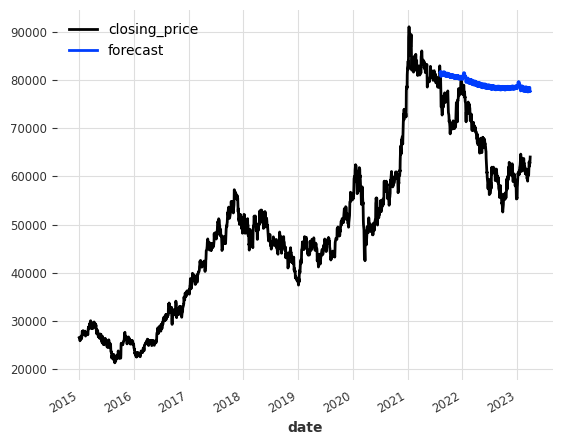

In [76]:
# 1. past_covariates를 아무것도 주지 않았을 경우 상승, 하강이 그럴싸하게 나옴. 전부를 주었을 경우 하강만 나옴.
i = 3
predicted_series_scaled = model.predict(n=len(list_val_series_scaled[i]),
                                        num_samples=500,
                                        series=list_train_series_scaled[i],
                                        past_covariates=list_past_cov_scaled[i],
                                        future_covariates=list_future_cov_scaled[i],)
prediction = list_scaler[i].inverse_transform(predicted_series_scaled)
list_stock_timeseries[i].plot()
prediction.plot(label="forecast")
plt.legend()

In [51]:
prediction

<TimeSeries (DataArray) (date: 1185, component: 1, sample: 1)>
array([[[69776.50376826]],

       [[69218.30993185]],

       [[68607.04778427]],

       ...,

       [[23409.76201275]],

       [[23409.76185116]],

       [[23409.76169163]]])
Coordinates:
  * date       (date) datetime64[ns] 2018-09-17 2018-09-18 ... 2023-03-31
  * component  (component) object 'price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None